In [2]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Define directories and LLMs
GAME_DIRS = ['guessing_game', 'divide_dollar', 'public_goods', 'diner_dilemma', 'battle_royale', 'pirate_game']
LLMS = ['<gvHK3Q2>', '<Z3cCMo0>', '<qqOBXB0>', '<3P26cpI>', '<JLI84K7>', '<my9FQ38>', '<jHLiFlg>', '<HzpuDbC>', '<X9x73kd>', '<xoEciVX>', '<RfelEFA>', '<pKbLE9I>']
RUNS = [1, 2, 3, 4, 5]
DATA_PATH = './processed_results'  # Base path for directories
out_dir = "./reproduced_results"

In [4]:
# LLM features from table
LLM_FEATURES = {
    '<gvHK3Q2>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<Z3cCMo0>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<qqOBXB0>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<3P26cpI>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<JLI84K7>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<my9FQ38>': {
        'params': np.nan,
        'layers': np.nan,
        'hidden_dim': np.nan,
        'hidden_act': 'Not disclosed',
        'inter_dim': np.nan,
        'max_pos_emb': np.nan,
        'attn_heads': np.nan,
        'kv_heads': np.nan,
        'vocab_size': np.nan,
    },
    '<jHLiFlg>': {
        'params': 8.03e9,
        'layers': 32,
        'hidden_dim': 4096,
        'hidden_act': 'silu',
        'inter_dim': 14336,
        'max_pos_emb': 131072,
        'attn_heads': 32,
        'kv_heads': 8,
        'vocab_size': 128256,
    },
    '<HzpuDbC>': {
        'params': 70.6e9,
        'layers': 80,
        'hidden_dim': 8192,
        'hidden_act': 'silu',
        'inter_dim': 28672,
        'max_pos_emb': 131072,
        'attn_heads': 64,
        'kv_heads': 8,
        'vocab_size': 128256,
    },
    '<X9x73kd>': {
        'params': 406e9,
        'layers': 126,
        'hidden_dim': 16384,
        'hidden_act': 'silu',
        'inter_dim': 53248,
        'max_pos_emb': 131072,
        'attn_heads': 128,
        'kv_heads': 8,
        'vocab_size': 128256,
    },
    '<xoEciVX>': {
        'params': 46.7e9,
        'layers': 32,
        'hidden_dim': 4096,
        'hidden_act': 'silu',
        'inter_dim': 14336,
        'max_pos_emb': 32768,
        'attn_heads': 32,
        'kv_heads': 8,
        'vocab_size': 32000,
    },
    '<RfelEFA>': {
        'params': 141e9,
        'layers': 56,
        'hidden_dim': 6144,
        'hidden_act': 'silu',
        'inter_dim': 16384,
        'max_pos_emb': 65536,
        'attn_heads': 48,
        'kv_heads': 8,
        'vocab_size': 32000,
    },
    '<pKbLE9I>': {
        'params': 72.7e9,
        'layers': 80,
        'hidden_dim': 8192,
        'hidden_act': 'silu',
        'inter_dim': 29568,
        'max_pos_emb': 131072,
        'attn_heads': 64,
        'kv_heads': 8,
        'vocab_size': 152064,
    }
}

In [5]:
# Helper to load JSON
def load_json(game_dir, llm, run):
    file = f"{llm}_{game_dir}_v1_run{run}.json"
    path = os.path.join(DATA_PATH, game_dir, file)
    with open(path, 'r') as f:
        return json.load(f)

In [6]:
# Preprocess and compute metrics per game
def compute_metrics(game_dir, data):
    meta = data['meta']
    records = data['round_records']
    rounds = len(records)
    if game_dir == 'guessing_game':
        guesses = [[r['response'] for r in rec['responses']] for rec in records]
        means = [rec['mean'] for rec in records]
        dev_ne = [abs(m - 0) for m in means]  # NE: 0
        level_k = [estimate_level_k(np.mean(g)) for g in guesses]  
        return {'dev_ne': np.mean(dev_ne), 'level_k_avg': np.mean(level_k)}
    elif game_dir == 'divide_dollar':
        bids = [[r['response'] for r in rec['responses']] for rec in records]
        totals = [rec['total_proposal'] for rec in records]
        success_rate = np.mean([t <= 100 for t in totals])
        dev_ne = [np.mean([abs(b - 10) for b in bid]) for bid in bids]
        return {'success_rate': success_rate, 'dev_ne_avg': np.mean(dev_ne)}
    elif game_dir == 'public_goods':
        contribs = [[r['response'] for r in rec['responses']] for rec in records]
        mean_contrib = [np.mean(c) for c in contribs]
        dev_ne = [m - 0 for m in mean_contrib]  # NE: 0
        return {'mean_contrib': np.mean(mean_contrib), 'dev_ne_avg': np.mean(dev_ne)}
    elif game_dir == 'diner_dilemma':
        choices = [[r['response'] for r in rec['responses']] for rec in records]
        prop_costly = [np.mean([1 if c == 'costly' else 0 for c in ch]) for ch in choices]
        dev_ne = [np.mean([p - 1 for p in prop_costly])]
        return {'prop_costly': np.mean(prop_costly), 'dev_ne': dev_ne[0]}
    elif game_dir == 'battle_royale':
        miss_actions = [1 if rec['action'] == 'miss' else 0 for rec in records]
        miss_prop = np.mean(miss_actions)
        return {'miss_prop': miss_prop, 'term_round': rounds}
    elif game_dir == 'pirate_game':
        optimal_prop = [96, 0, 1, 0, 1, 0, 1, 0, 1, 0]
        proposals = [sorted(rec['gold_distribution'], key=lambda x: x['player_id']) for rec in records]
        amounts = [[p['amount'] for p in prop] for prop in proposals]
        sims = [jaccard_sim(a, optimal_prop) for a in amounts]
        accept_rate = np.mean([1 if rec['proposal_accepted'] else 0 for rec in records])
        return {'prop_sim_opt': np.mean(sims), 'accept_rate': accept_rate, 'term_round': rounds}

In [7]:
# Custom: Estimate level-k for Guess 2/3
def estimate_level_k(mean_guess):
    levels = [50, 33.3, 22.2, 14.8, 9.9, 6.6, 4.4, 2.9, 1.9, 1.3, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1, 0]
    return np.argmin([abs(mean_guess - l) for l in levels])

In [8]:
# Custom: Jaccard similarity for proposals
def jaccard_sim(a, b):
    a_set = set(a)
    b_set = set(b)
    if len(a_set.union(b_set)) == 0:
        return 0
    return len(a_set.intersection(b_set)) / len(a_set.union(b_set))

In [9]:
# Aggregate data per run
all_data = []
for game in GAME_DIRS:
    for llm in LLMS:
        for run in RUNS:
            raw = load_json(game, llm, run)
            metrics = compute_metrics(game, raw)
            metrics.update({'game': game, 'llm': llm, 'run': run})
            all_data.append(metrics)

In [10]:
df = pd.DataFrame(all_data)

In [11]:
df

,dev_ne,level_k_avg,game,llm,run,success_rate,dev_ne_avg,mean_contrib,prop_costly,miss_prop,term_round,prop_sim_opt,accept_rate
0,58.880,0.0,guessing_game,<gvHK3Q2>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58.280,0.0,guessing_game,<gvHK3Q2>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57.810,0.0,guessing_game,<gvHK3Q2>,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59.180,0.0,guessing_game,<gvHK3Q2>,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58.725,0.0,guessing_game,<gvHK3Q2>,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,pirate_game,<pKbLE9I>,1,NaN,NaN,NaN,NaN,NaN,1.0,0.5,1.000000
356,NaN,NaN,pirate_game,<pKbLE9I>,2,NaN,NaN,NaN,NaN,NaN,3.0,0.5,0.333333
357,NaN,NaN,pirate_game,<pKbLE9I>,3,NaN,NaN,NaN,NaN,NaN,1.0,0.4,1.000000
358,NaN,NaN,pirate_game,<pKbLE9I>,4,NaN,NaN,NaN,NaN,NaN,2.0,0.5,0.500000


In [12]:
# Compute SRS
def compute_srs(row):
    game = row['game']
    if game == 'guessing_game':
        norm_dev = row.get('dev_ne', 0) / 100
    elif game == 'divide_dollar':
        norm_dev = row.get('dev_ne_avg', 0) / 100
    elif game == 'public_goods':
        norm_dev = row.get('dev_ne_avg', 0) / 20
    elif game == 'diner_dilemma':
        norm_dev = abs(row.get('dev_ne', 0))
    else:  # sequential
        term_round = row.get('term_round', 20)
        norm_dev = (term_round - 1) / 19
    return 1 - norm_dev

In [13]:
df['srs'] = df.apply(compute_srs, axis=1)

In [14]:
df

,dev_ne,level_k_avg,game,llm,run,success_rate,dev_ne_avg,mean_contrib,prop_costly,miss_prop,term_round,prop_sim_opt,accept_rate,srs
0,58.880,0.0,guessing_game,<gvHK3Q2>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.411200
1,58.280,0.0,guessing_game,<gvHK3Q2>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.417200
2,57.810,0.0,guessing_game,<gvHK3Q2>,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421900
3,59.180,0.0,guessing_game,<gvHK3Q2>,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.408200
4,58.725,0.0,guessing_game,<gvHK3Q2>,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,pirate_game,<pKbLE9I>,1,NaN,NaN,NaN,NaN,NaN,1.0,0.5,1.000000,1.000000
356,NaN,NaN,pirate_game,<pKbLE9I>,2,NaN,NaN,NaN,NaN,NaN,3.0,0.5,0.333333,0.894737
357,NaN,NaN,pirate_game,<pKbLE9I>,3,NaN,NaN,NaN,NaN,NaN,1.0,0.4,1.000000,1.000000
358,NaN,NaN,pirate_game,<pKbLE9I>,4,NaN,NaN,NaN,NaN,NaN,2.0,0.5,0.500000,0.947368


In [15]:
df_agg = df.groupby(['llm', 'game']).mean(numeric_only=True).reset_index()

In [16]:
df_agg

,llm,game,dev_ne,level_k_avg,run,success_rate,dev_ne_avg,mean_contrib,prop_costly,miss_prop,term_round,prop_sim_opt,accept_rate,srs
0,<3P26cpI>,battle_royale,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.263275,19.4,NaN,NaN,0.031579
1,<3P26cpI>,diner_dilemma,-0.893,NaN,3.0,NaN,NaN,NaN,0.107,NaN,NaN,NaN,NaN,0.107000
2,<3P26cpI>,divide_dollar,NaN,NaN,3.0,0.90,0.850,NaN,NaN,NaN,NaN,NaN,NaN,0.991500
3,<3P26cpI>,guessing_game,5.716,7.15,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942840
4,<3P26cpI>,pirate_game,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.2,0.600000,0.706667,0.936842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,<xoEciVX>,diner_dilemma,-0.668,NaN,3.0,NaN,NaN,NaN,0.332,NaN,NaN,NaN,NaN,0.332000
68,<xoEciVX>,divide_dollar,NaN,NaN,3.0,0.02,13.469,NaN,NaN,NaN,NaN,NaN,NaN,0.865310
69,<xoEciVX>,guessing_game,8.219,7.31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.917810
70,<xoEciVX>,pirate_game,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.8,0.240667,0.386667,0.852632


In [17]:
# verification
avg_srs_coop = df_agg[df_agg['game'].isin(['guessing_game', 'divide_dollar'])]['srs'].mean()

avg_srs_coop

0.8990808333333332

In [18]:
# verification
avg_srs_betray = df_agg[df_agg['game'].isin(['public_goods', 'diner_dilemma'])]['srs'].mean()

avg_srs_betray

0.48458958333333335

In [19]:
# verification
avg_srs_seq = df_agg[df_agg['game'].isin(['battle_royale', 'pirate_game'])]['srs'].mean()

avg_srs_seq

0.512719298245614

In [20]:
# Features df
features_df = pd.DataFrame(LLM_FEATURES).T.reset_index().rename(columns={'index': 'llm'})

In [21]:
features_df

,llm,params,layers,hidden_dim,hidden_act,inter_dim,max_pos_emb,attn_heads,kv_heads,vocab_size
0,<gvHK3Q2>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
1,<Z3cCMo0>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
2,<qqOBXB0>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
3,<3P26cpI>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
4,<JLI84K7>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
5,<my9FQ38>,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
6,<jHLiFlg>,8030000000.0,32,4096,silu,14336,131072,32,8,128256
7,<HzpuDbC>,70600000000.0,80,8192,silu,28672,131072,64,8,128256
8,<X9x73kd>,406000000000.0,126,16384,silu,53248,131072,128,8,128256
9,<xoEciVX>,46700000000.0,32,4096,silu,14336,32768,32,8,32000


In [22]:
df_merged = df_agg.merge(features_df, on='llm')

In [23]:
df_merged

,llm,game,dev_ne,level_k_avg,run,success_rate,dev_ne_avg,mean_contrib,prop_costly,miss_prop,...,srs,params,layers,hidden_dim,hidden_act,inter_dim,max_pos_emb,attn_heads,kv_heads,vocab_size
0,<3P26cpI>,battle_royale,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.263275,...,0.031579,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
1,<3P26cpI>,diner_dilemma,-0.893,NaN,3.0,NaN,NaN,NaN,0.107,NaN,...,0.107000,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
2,<3P26cpI>,divide_dollar,NaN,NaN,3.0,0.90,0.850,NaN,NaN,NaN,...,0.991500,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
3,<3P26cpI>,guessing_game,5.716,7.15,3.0,NaN,NaN,NaN,NaN,NaN,...,0.942840,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
4,<3P26cpI>,pirate_game,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,0.936842,NaN,NaN,NaN,Not disclosed,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,<xoEciVX>,diner_dilemma,-0.668,NaN,3.0,NaN,NaN,NaN,0.332,NaN,...,0.332000,46700000000.0,32,4096,silu,14336,32768,32,8,32000
68,<xoEciVX>,divide_dollar,NaN,NaN,3.0,0.02,13.469,NaN,NaN,NaN,...,0.865310,46700000000.0,32,4096,silu,14336,32768,32,8,32000
69,<xoEciVX>,guessing_game,8.219,7.31,3.0,NaN,NaN,NaN,NaN,NaN,...,0.917810,46700000000.0,32,4096,silu,14336,32768,32,8,32000
70,<xoEciVX>,pirate_game,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,0.852632,46700000000.0,32,4096,silu,14336,32768,32,8,32000


In [24]:
# Statistical tests
# H1: t-test large vs small
large = df_merged[df_merged['params'] > 70e9]['srs'].dropna()
small = df_merged[df_merged['params'] <= 70e9]['srs'].dropna()
t_stat, p_val = stats.ttest_ind(large, small, nan_policy='omit')
print(f"H1 t-test: t={t_stat}, p={p_val}")

H1 t-test: t=0.6975787111017883, p=0.4901838580549355


In [25]:
# ANOVA for LLM differences
groups = [df_agg[df_agg['llm'] == l]['srs'].dropna() for l in LLMS]
anova_res = stats.f_oneway(*[g for g in groups if len(g) > 1])
print(f"ANOVA: F={anova_res.statistic}, p={anova_res.pvalue}")

ANOVA: F=0.13613519302626526, p=0.999498325537741


In [26]:
# Correlations (H4)
# numeric_df = df_merged.select_dtypes(include=[np.number])
numeric_df = df_merged.loc[:, ["srs", 'params', 'layers', 'hidden_dim', "inter_dim", "max_pos_emb", "attn_heads", "vocab_size"]]
corr = numeric_df.corr(method='spearman').get('srs', pd.Series()).reindex(['params', 'layers', 'hidden_dim', "inter_dim", "max_pos_emb", "attn_heads", "vocab_size"])
print("Correlations with SRS:", corr)

Correlations with SRS: params         0.135442
layers         0.201973
hidden_dim     0.201973
inter_dim      0.193023
max_pos_emb    0.118109
attn_heads     0.201973
vocab_size     0.102744
Name: srs, dtype: float64


In [27]:
# Mixed model for evolution (H3; example for guessing_game)
gg_df = df[df['game'] == 'guessing_game'].copy()
gg_df['dev_ne'] = gg_df['dev_ne'].astype(float)
gg_df['run'] = gg_df['run'].astype(float)
gg_df['llm_id'] = pd.factorize(gg_df['llm'])[0]
mdl = mixedlm("dev_ne ~ run + (1|llm_id)", gg_df, groups=gg_df['llm_id'])
res = mdl.fit()
print(res.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dev_ne   
No. Observations: 60      Method:             REML     
No. Groups:       12      Scale:              6.3057   
Min. group size:  5       Log-Likelihood:     -166.0356
Max. group size:  5       Converged:          Yes      
Mean group size:  5.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    30.240    7.979  3.790 0.000 14.601 45.880
run           0.187    0.229  0.814 0.415 -0.263  0.636
1 | llm_id   -2.367    1.151 -2.056 0.040 -4.624 -0.110
Group Var   184.355   36.404                           



In [28]:
# Predictive model (innovation)
X = df_merged[['params', 'layers', 'hidden_dim']].fillna(0)
y = df_merged['srs'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

/tmp/ipykernel_2804/1278076928.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = df_merged[['params', 'layers', 'hidden_dim']].fillna(0)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
preds = model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, preds)
print(f"Predictive MSE: {mse}")

Predictive MSE: 0.1968444179523914


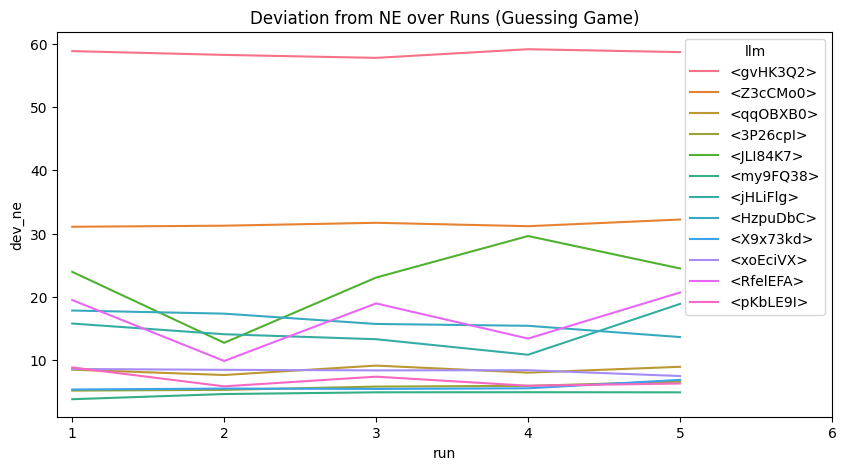

In [31]:
# Visualizations
# Line plot: Dev over runs for guessing_game
plt.figure(figsize=(10,5))
plt.xlim(0.9, 6.0)
sns.lineplot(data=gg_df, x='run', y='dev_ne', hue='llm')
plt.title('Deviation from NE over Runs (Guessing Game)')
plt.savefig(f'{out_dir}/dev_over_runs.png', bbox_inches="tight")

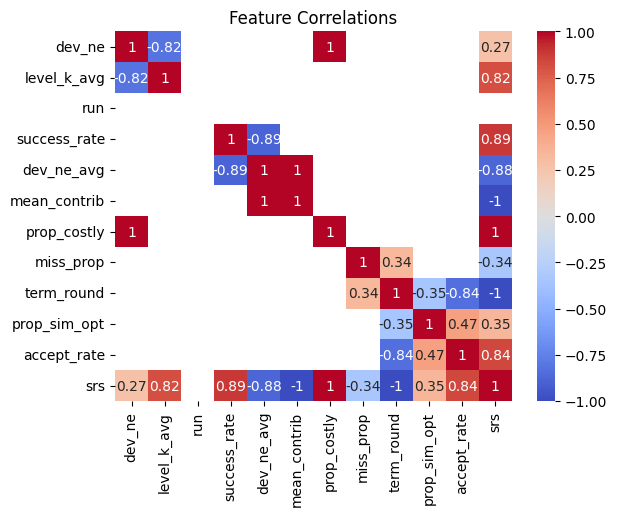

In [32]:
# Heatmap: Correlations
plt.figure()
numeric_df = df_merged.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.savefig(f'{out_dir}/corr_heatmap.png', bbox_inches="tight")

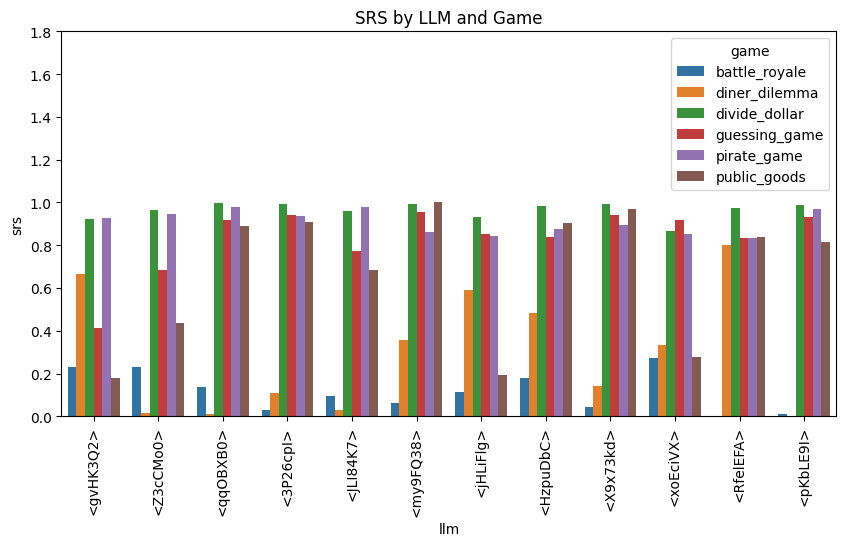

In [33]:
# Bar plot: SRS per LLM
plt.figure(figsize=(10,5))
plt.ylim(0, 1.8)
df_agg['llm'] = pd.Categorical(df_agg['llm'], categories=LLMS, ordered=True)
sns.barplot(data=df_agg, x='llm', y='srs', hue='game')
plt.title('SRS by LLM and Game')
plt.xticks(rotation=90)
plt.savefig(f'{out_dir}/srs_bar.png', bbox_inches="tight")

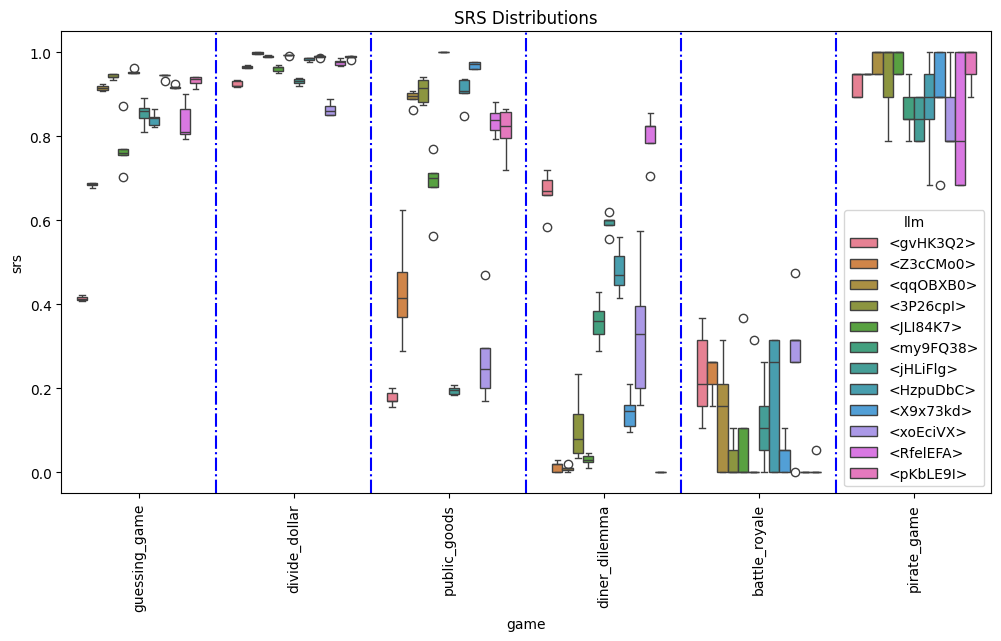

In [34]:
# Box plot: SRS distributions
plt.figure(figsize=(12,6))
for i in range(5):
    plt.axvline(x = i+0.5, color = 'b', linestyle='-.')
sns.boxplot(data=df, x='game', y='srs', hue='llm')
plt.title('SRS Distributions')
plt.xticks(rotation=90)
plt.savefig(f'{out_dir}/srs_box.png', bbox_inches="tight")

In [35]:
# Save aggregates
df_agg.to_csv(f'{out_dir}/aggregated_metrics.csv', index=False)